## Imports

In [1]:
import torch
from torch.utils.data import DataLoader
from data import ParenthesizationDataset
from model import Model
from train import train_one_epoch, compute_validation_loss
from evaluate import evaluate_model, predict
from interpret import plot_linear_layer, incorrect_predictions, token_contributions, activations
import matplotlib.pyplot as plt

## Initialize model, loaders, loss function, optimizer
`checkpoint_epochs` is the number of epochs before a checkpoint is saved. Use `data_prefix` to choose the "small" dataset.

In [2]:
epochs = 20
checkpoint_epochs = 2
batch_size = 64
d_model = 16
nhead = 4
num_layers = 2
n_vocab = 4
data_prefix = "small_"

training_dataset = ParenthesizationDataset(f"{data_prefix}training")
validation_dataset = ParenthesizationDataset(f"{data_prefix}validation")
test_dataset = ParenthesizationDataset(f"{data_prefix}test")

training_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

model = Model(n_vocab, d_model, nhead, num_layers)
loss_fn = torch.nn.CrossEntropyLoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train model
`start_epoch` can be set to a value greater than 0 to resume training from a checkpoint.

In [3]:
start_epoch = 19

training_loss = []
validation_loss = []
best_validation_loss = float("inf")

def save():
    torch.save({
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'training_loss': training_loss,
      'validation_loss': validation_loss
    }, f"checkpoints/epoch_{epoch}.pth")

def resume(epoch):
    global training_loss, validation_loss
    checkpoint = torch.load(f"checkpoints/epoch_{epoch}.pth")
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    training_loss = checkpoint["training_loss"]
    validation_loss = checkpoint["validation_loss"]

if start_epoch > 0:
    resume(start_epoch)
    start_epoch += 1

for epoch in range(start_epoch, epochs):
    model.train(True)
    training_loss.append(train_one_epoch(training_loader, model, loss_fn, optimizer))
    validation_loss.append(compute_validation_loss(validation_loader, model, loss_fn))
    print(f"Epoch {epoch}, Training Loss {training_loss[-1]}, Validation Loss {validation_loss[-1]}")

    if (epoch+1) % checkpoint_epochs == 0:
        save()

# Plot the loss curve for training and validation

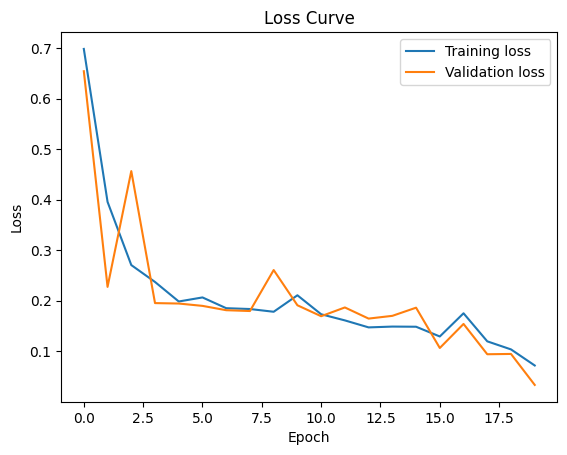

In [4]:
# Plot loss function
plt.plot(training_loss, label="Training loss")
plt.plot(validation_loss, label="Validation loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.show()

# Evaluate the model and plot the confusion matrix

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:384: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/NestedTensorImpl.cpp:179.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


Training data set accuracy:
Accuracy for class 0 = 96.4068209500609%
Accuracy for class 1 = 99.69586374695864%
Overall accuracy = 98.05234327449787%


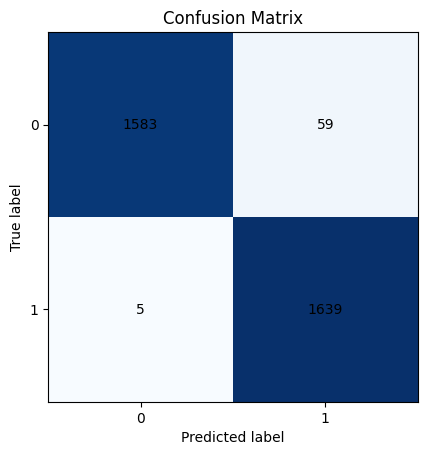

Validation data set accuracy:
Accuracy for class 0 = 99.01960784313725%
Accuracy for class 1 = 100.0%
Overall accuracy = 99.50980392156863%


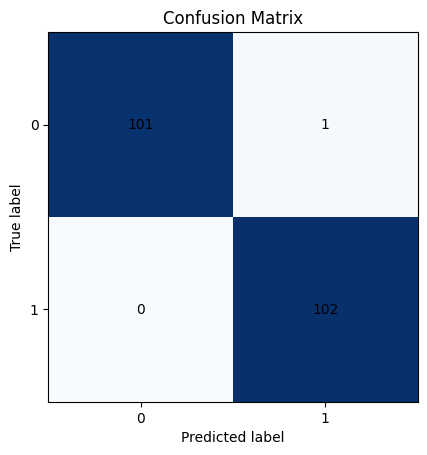

Test data set accuracy:
Accuracy for class 0 = 96.42857142857143%
Accuracy for class 1 = 100.0%
Overall accuracy = 98.21428571428571%


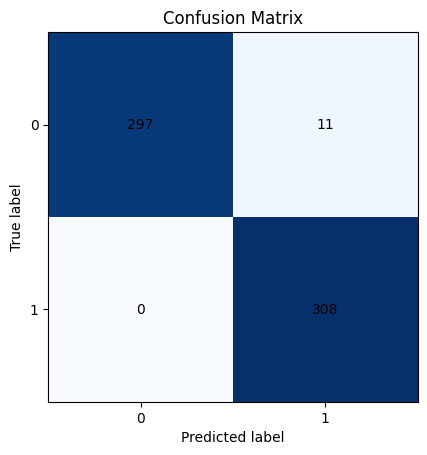

In [5]:
training_confusion_matrix = evaluate_model(model, training_loader)
validation_confusion_matrix = evaluate_model(model, validation_loader)
test_confusion_matrix = evaluate_model(model, test_loader)

print("Training data set accuracy:")
training_confusion_matrix.print_accuracy()
training_confusion_matrix.plot()

print("Validation data set accuracy:")
validation_confusion_matrix.print_accuracy()
validation_confusion_matrix.plot()

print("Test data set accuracy:")
test_confusion_matrix.print_accuracy()
test_confusion_matrix.plot()

# Interpretation
In this section you will try various techniques to interpret the model. Insert additional notebook cells as need to do the following:

1. Construct some test cases of varying lengths and display the model's predictions.
2. Compute the list of incorrect predictions and display some examples of them.
3. For each incorrect prediction, plot the token contributions as a heatmap.
4. For each position from 0 to 21, loop over all inputs in the test set and plot a histogram of the token contributions for that position.
5. Plot the heatmap for the projection layer and the second linear layer in the feedforward.
6. Loop over all inputs in the test set and count the activations in the feedforward layer. Plot the activations as a histogram to see which features in the feedforward layer are activated the most.

1: Construct some test cases of varying lengths and display the model's predictions

In [6]:
print(predict(model, "((((()))))"))
print(1)
print(predict(model, "()(()()"))
print(0)
print(predict(model, "())"))
print(0)
print(predict(model, "(())"))
print(1)
print(predict(model, "((()))"))
print(1)
print(predict(model, "(()())("))
print(0)
print(predict(model, ")))))"))
print(0)
print(predict(model, ")()"))
print(0)
print(predict(model, "((())))()"))
print(0)

tensor(1)
1
tensor(0)
0
tensor(1)
0
tensor(1)
1
tensor(1)
1
tensor(0)
0
tensor(0)
0
tensor(0)
0
tensor(1)
0


Compute the list of incorrect predictions and display some of them

In [7]:
output = incorrect_predictions(model, test_loader)

for i in range(2):
    print(f"Label {i}")
    print(output[i])


Label 0
[[2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [2, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [2, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [2, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [2, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [2, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [2, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [2, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [2, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [2, 0, 1, 0

plot linear layer

Linear(in_features=2048, out_features=16, bias=True)


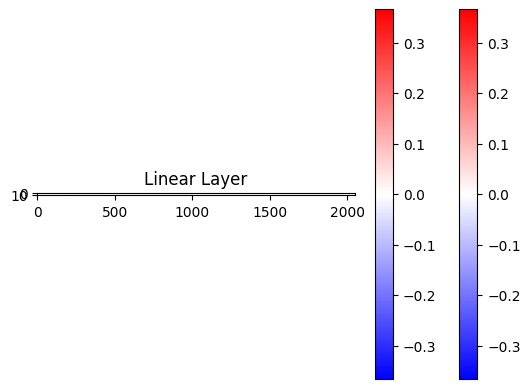

In [8]:
layer = model.encoder.layers[1].linear2
print(layer)
plot_linear_layer(layer)





Token contributions for incorrect predictions

In [9]:
from data import parenthesization_to_tensor
import matplotlib.pyplot as plt
paren = parenthesization_to_tensor("(())))")
output = token_contributions(model, paren)
print(output)


[tensor(0), tensor(0), tensor(0), tensor(-1), tensor(-1), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0), tensor(0)]


for each incorect prediction, plot the token contributions as a heat map:

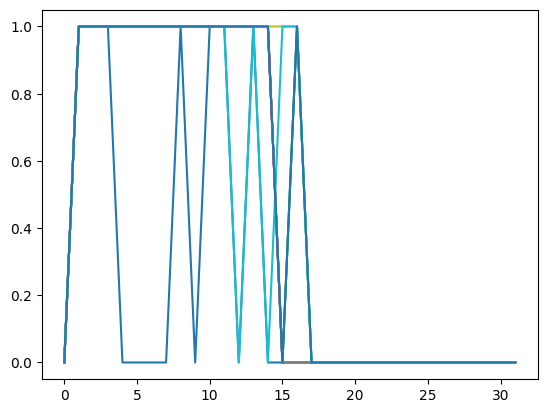

In [10]:
import matplotlib.pyplot as plt
wrong_predictions = incorrect_predictions(model, test_loader)
for class_type in wrong_predictions:
    for pred in class_type:
        output = token_contributions(model, torch.tensor(pred))
        plt.plot(output)


activations

In [11]:
activations(model, test_loader)

AttributeError: 'Tensor' object has no attribute 'encoder'